In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%matplotlib inline
import sys
import os
import datetime

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *


In [3]:
n = 500
k = 20

In [4]:
def GetRandomData(n, g, k):
    U, V, binaryPathwayMatrix, phenotypeGenes = GenerateSimulatedData(n, g, k, int(g/k), covariateU=True)
    X = np.dot(U, V.T)
    neighbors = GetNeighborDictionary(binaryPathwayMatrix, percentileThreshold=95)
    return X, phenotypeGenes, neighbors

In [5]:
eta     = 0.014861
lamb1   = 0.003966
lamb2   = 0.018775

In [15]:
numReps = 100 #CHANGE TO 50
intersectionGap = 1
numPlotPoints = 100
num_epochs = 1
gene_num_list = [1000, 3000, 5000, 7000] #CHANGE TO 1000, 3000 ...

def TrainReps(rep, n, k):
    #needs: n, g, k
    with open('NumGenesProgress.txt', 'a') as f:
        f.write('Started rep {} at time {}\n'.format(rep, datetime.datetime.now()))

    X_1, phenotypeGenes_1, neighbors_1 = GetRandomData(n=n, g=gene_num_list[0], k=k)
    X_3, phenotypeGenes_3, neighbors_3 = GetRandomData(n=n, g=gene_num_list[1], k=k)
    X_5, phenotypeGenes_5, neighbors_5 = GetRandomData(n=n, g=gene_num_list[2], k=k)
    X_7, phenotypeGenes_7, neighbors_7 = GetRandomData(n=n, g=gene_num_list[3], k=k)
    
    pca = PCA(n_components=50)
    pca.fit(X_1.T)
    latent_dim_1 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
    
    pca.fit(X_3.T)
    latent_dim_3 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
    
    pca.fit(X_5.T)
    latent_dim_5 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
    
    pca.fit(X_7.T)
    latent_dim_7 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
    
    #Train on all of the data
    U_pred_init, V_pred_init = CreateLatentVariables(n, gene_num_list[0], latent_dim_1)
    U_pred_1, V_pred_1           = FactorizeMatrix(X_1, U_pred_init, V_pred_init, neighbors_1, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=num_epochs)
    
    U_pred_init, V_pred_init = CreateLatentVariables(n, gene_num_list[1], latent_dim_3)
    U_pred_3, V_pred_3           = FactorizeMatrix(X_3, U_pred_init, V_pred_init, neighbors_3, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=num_epochs)
    
    U_pred_init, V_pred_init = CreateLatentVariables(n, gene_num_list[2], latent_dim_5)
    U_pred_5, V_pred_5           = FactorizeMatrix(X_5, U_pred_init, V_pred_init, neighbors_5, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=num_epochs)
    
    U_pred_init, V_pred_init = CreateLatentVariables(n, gene_num_list[3], latent_dim_7)
    U_pred_7, V_pred_7           = FactorizeMatrix(X_7, U_pred_init, V_pred_init, neighbors_7, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=num_epochs)
    
    tg_1 = GetTopGenes(V_pred_1, 0, np.arange(1, gene_num_list[0]))
    tg_3 = GetTopGenes(V_pred_3, 0, np.arange(1, gene_num_list[1]))
    tg_5 = GetTopGenes(V_pred_5, 0, np.arange(1, gene_num_list[2]))
    tg_7 = GetTopGenes(V_pred_7, 0, np.arange(1, gene_num_list[3]))
    
    intersection_mat = np.zeros((4, numPlotPoints))
    index = 0
    
    intersectionGap = int(gene_num_list[0] / 100)
    for i in range(0, gene_num_list[0], intersectionGap):
        intersection_mat[0, int(i / intersectionGap)] = np.sum(np.in1d(tg_1[i:i+intersectionGap], phenotypeGenes_1))
    intersection_mat[0, :] /= len(phenotypeGenes_1)
    
    intersectionGap = int(gene_num_list[1] / 100)
    for i in range(0, gene_num_list[1], intersectionGap):
        intersection_mat[1, int(i / intersectionGap)] = np.sum(np.in1d(tg_3[i:i+intersectionGap], phenotypeGenes_3))
    intersection_mat[1, :] /= len(phenotypeGenes_3)
    
    intersectionGap = int(gene_num_list[2] / 100)
    for i in range(0, gene_num_list[2], intersectionGap):
        intersection_mat[2, int(i / intersectionGap)] = np.sum(np.in1d(tg_5[i:i+intersectionGap], phenotypeGenes_5))
    intersection_mat[2, :] /= len(phenotypeGenes_5)
    
    intersectionGap = int(gene_num_list[3] / 100)
    for i in range(0, gene_num_list[3], intersectionGap):
        intersection_mat[3, int(i / intersectionGap)] = np.sum(np.in1d(tg_7[i:i+intersectionGap], phenotypeGenes_7))
    intersection_mat[3, :] /= len(phenotypeGenes_7)

    with open('NumGenesProgress.txt', 'a') as f:
        f.write('Ended rep {} at time {}\n'.format(rep, datetime.datetime.now()))
    return intersection_mat

In [ ]:
numProcesses = 20
p = Pool(numProcesses)
tg_zipped = p.map(partial(TrainReps, n=n, k=k), range(numReps))
p.close()
p.join()

In [ ]:
tg_stacked = np.stack(tg_zipped, axis=0) #of shape numReps, 4, numPlotPoints
tg_summed  = np.cumsum(tg_stacked, axis=2) #cumulative sum over numPlotPoints

In [ ]:
dot_1  = tg_summed[:, 0, :]
dot_3  = tg_summed[:, 1, :]
dot_5  = tg_summed[:, 2, :]
dot_7  = tg_summed[:, 3, :]

In [ ]:
x_values = np.arange(100) / 100
dot_1_df = MatToMeltDF(dot_1, group_name='1000genes', x_values=x_values)

dot_3_df = MatToMeltDF(dot_3, group_name='3000genes', x_values=x_values)

dot_5_df = MatToMeltDF(dot_5, group_name='5000genes', x_values=x_values)
dot_7_df = MatToMeltDF(dot_7, group_name='7000genes', x_values=x_values)

In [20]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

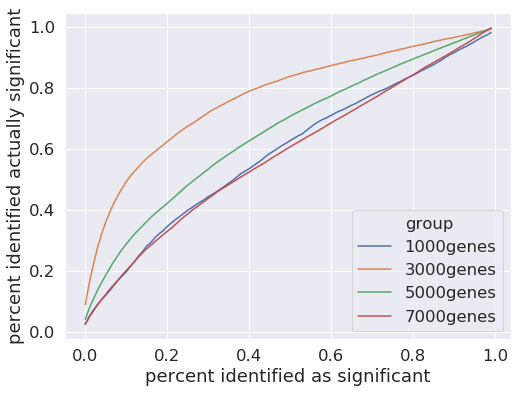

In [23]:
sns.lineplot(x='percent identified as significant', y='percent identified actually significant', hue='group', 
             data=pd.concat([dot_1_df, dot_3_df, dot_5_df, dot_7_df]), ci=None)

In [24]:
concat_df = pd.concat([dot_1_df, dot_3_df, dot_5_df, dot_7_df])

In [25]:
concat_df.to_csv('../../DataFrames/NumGenesDF.csv')